<a href="https://colab.research.google.com/github/mroshan454/Replicating-ViT-Research-Paper/blob/main/Replicating_The_ViT_Paper_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating The Vision Transformer Research Paper from Scratch

In this notebook , I will be attempting to replicate the 2020 Research paper:

 "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE ,
Where the Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring sub- stantially fewer computational resources to train.

The goal of machine learning research paper replicating is to turn a ML Research Paper into usable code.





## 0. Importing required libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mroshan454/Replicating-ViT-Research-Paper
    !mv Replicating-ViT-Research-Paper/going_modular/going_modular ./going_modular
    !rm -rf Replicating-ViT-Research-Paper
    from going_modular  import data_setup, engine
    from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Replicating-ViT-Research-Paper'...
remote: Enumerating objects: 431, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 431 (delta 36), reused 48 (delta 16), pack-reused 357 (from 2)
Receiving objects: 100% (431/431), 98.46 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

#Setup path to data folder
data_path = Path("data/")
image_path = data_path / "plant_disease"

#If image folder does'nt exist , download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory , creating one....")
  image_path.mkdir(parents=True, exist_ok=True)

#Download happy , angry , sad data
with open(data_path / "plant_disease.zip","wb") as f:
  request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/data/Plant_Disease_ViT.zip")
  print("Downloading data...")
  f.write(request.content)

#Unzip happy,angry,sad data
with zipfile.ZipFile(data_path / "plant_disease.zip","r") as zip_ref:
  print("Unzipping plant_disease data...")
  zip_ref.extractall(image_path)

#Remove zip file
os.remove(data_path / "plant_disease.zip")


Did not find data/plant_disease directory , creating one....
Unzipping plant_disease data...


In [5]:
#Setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/plant_disease/train'), PosixPath('data/plant_disease/test'))

## 2. Create datasets and dataloaders

Now we'll turn the data into PyTorch `Datasets` and `Dataloader's`

In [6]:
from torchvision import datasets , transforms

#Create simple transforms
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

#Use image folder to create dataset
train_data = datasets.ImageFolder(root=train_dir, #Target folder of images
                                 transform=data_transform, #Transforms to perform on data (images)
                                 target_transform=None) #Transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 800
    Root location: data/plant_disease/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 240
    Root location: data/plant_disease/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [7]:
#Get class names as a list
class_names = train_data.classes
class_names

['Pepper_Bell_Bacterial_Spot',
 'Pepper_Bell_Healthy',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_blight',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [8]:
#Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Pepper_Bell_Bacterial_Spot': 0,
 'Pepper_Bell_Healthy': 1,
 'Potato_Early_Blight': 2,
 'Potato_Healthy': 3,
 'Potato_Late_blight': 4,
 'Tomato_Early_blight': 5,
 'Tomato_Late_blight': 6,
 'Tomato_healthy': 7}

In [9]:
#Check lengths
len(train_data), len(test_data)

(800, 240)

data/plant_disease/test/Tomato_Late_blight/a6007dbc-3a2f-4c1e-9ec6-28d7d3a17f28___GHLB_PS Leaf 13 Day 8.jpg
Tomato_Late_blight
Random Image Path: data/plant_disease/test/Tomato_Late_blight/a6007dbc-3a2f-4c1e-9ec6-28d7d3a17f28___GHLB_PS Leaf 13 Day 8.jpg
Image Class : Tomato_Late_blight
Image Height : 256
Image Width : 256


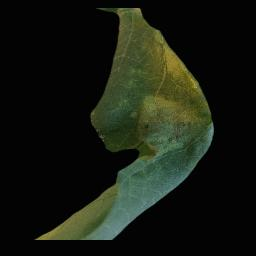

In [10]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1.Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from the path name ( the image class is the name of the directory where the image is stored )
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

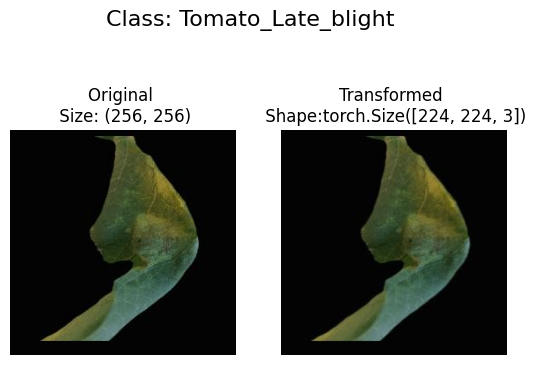

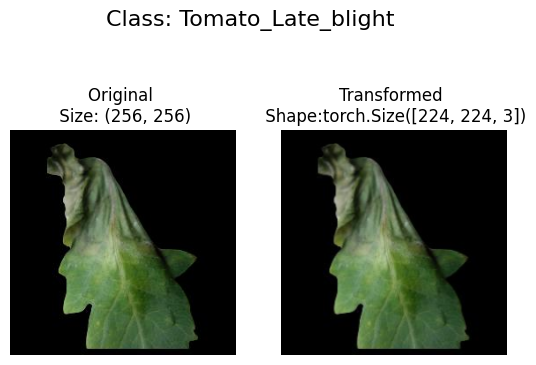

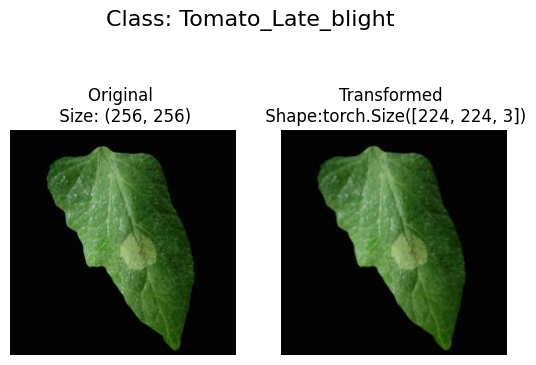

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths:list,transform,n=3,seed=42):
  """
  Selects random images from a path of image and loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig ,ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) #Note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [12]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ee42234f150>,
 <torch.utils.data.dataloader.DataLoader at 0x7ee4201a3dd0>)

## 3. Replicating ViT : Overview

Rather than looking at whole machine learning paper , we can make it more understandable by breaking it down into smaller blocks.

* **Inputs** - What goes into the model?(in our case,image tensors)
* **Outputs** - What comes out of the model/layer/block? (In our case, we want the model to output image classification labels)
* **Layers** - Takes an input , manipulates it with a function eg:Self-Attention.
* **Blocks** - A collection of layers.
* **Model or Architecture** - A collection of blocks.

### 3.1 ViT Figure 1
<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Fig.1.VIT.png?raw=true" width=900 alt="figure 1 from the original vision transformer paper"/>


**Figure 1 Explained Visually:**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/1.png?raw=true" width=900 alt="figure 1 explained visually"/>

### 3.2 Four Equations

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Four%20Equations.png?raw=true" width=900 alt="four equations"/>

These are the four equations that is used throughout this research paper.


#### **Equation 1: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/2.png?raw=true" width=900 alt="equation 1 explained visually"/>

The Equation 1 shows that the images are converted into patches , and linearly embedd each other together and one extra learnable class embedding is added , and after that each position embeddings are given to each patches including the Extra Learnable class embedding.

We are using 1-D Patch Embeddings because , there is no significant performance gain from using the advanced 2D- Aware position embeddings.(Appendix D.4)

The Equation is converted into a pseudocode later which we can turn it into PyTorch code.


#### **Equation 2 & 3: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/3.png?raw=true" width=900 alt="equation 3 explained visually"/>

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/4.png?raw=true" width=900 alt="equation 4 explained visually"/>

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

#### **Equation 4: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/5.png?raw=true" width=900 alt="equation 5 explained visually"/>

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathrm{z}_0^0=\mathrm{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathrm{z}_L^0$ ) serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.


* MLP = Multilayer Perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine tuning time


## **Table 1**


| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

* ViT-Base , ViT-Large and ViT-Huge are all different sizes of the same model architecture.

* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

For Starting we will be Replicating ViT Base at First

## 4. Converting the Equation 1 into PyTorch code:

### Split Data into Patches and Creating Class , Position and Patch Embedding.

### 4.1 Calculate input and output shapes by hand

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape : $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^2 \cdot C\right)}$
* H = Height
* W = Width
* C = Color Channels
* P = Patch Size
* N = number of patches = (Height * Width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [13]:
#Creating Example values
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate the number of patches
num_patches = int((height*width) / patch_size**2)
num_patches


196

In [14]:
#Input shape
embedding_layer_input_shape = (height,width,color_channels)

#Output shape
embedding_layer_output_shape = (num_patches,patch_size**2 * color_channels)

print(f"Input Shape :{embedding_layer_input_shape}")
print(f"Output Shape: {embedding_layer_output_shape}")

Input Shape :(224, 224, 3)
Output Shape: (196, 768)


### 4.2. Turning  a single image into Patches

Let's visualise , visualise , visualise

In [15]:
# Get a batch of images
image_batch , label_batch = next(iter(train_dataloader))

#Get a single image and label from the batch
image , label = image_batch[0] , label_batch[0]


#View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

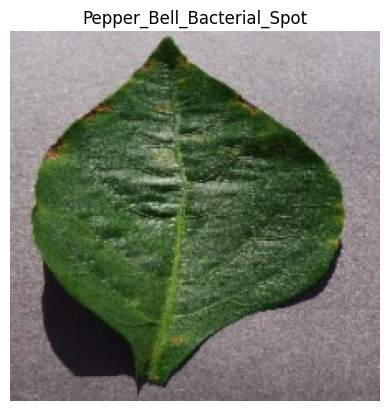

In [16]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
image.shape

torch.Size([3, 224, 224])

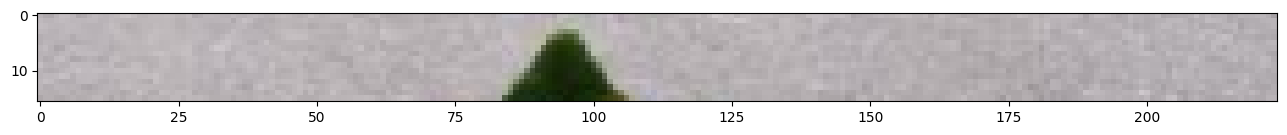

In [18]:
#Get the top row of the image
image_permuted = image.permute(1,2,0) #Converting the image to color channels last (H,W,C)

#Index to plot the top row of pixels
patch_size = 16  #In the research paper
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])


Number of patches per row/column : 14.0 
 Patch Size 16 pixels x 16 pixels


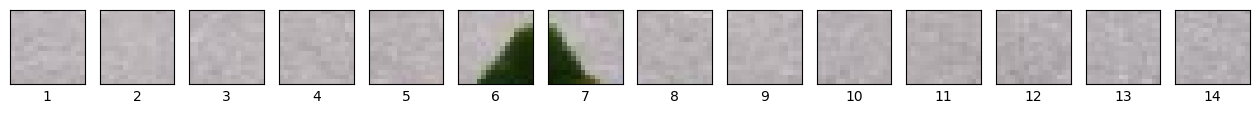

In [19]:
#Plot the top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f"Number of patches per row/column : {num_patches} \n Patch Size {patch_size} pixels x {patch_size} pixels")

#Create a series of Subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,#One column for each patch,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

#Iterate through the number of patches in the top row
for i , patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
    axs[i].set_xlabel(i+1) #Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row/column : 14.0 
 Patch Size 16 pixels x 16 pixels 
 Total Patches : 196.0


Text(0.5, 0.98, 'Pepper_Bell_Bacterial_Spot->Patchified Image')

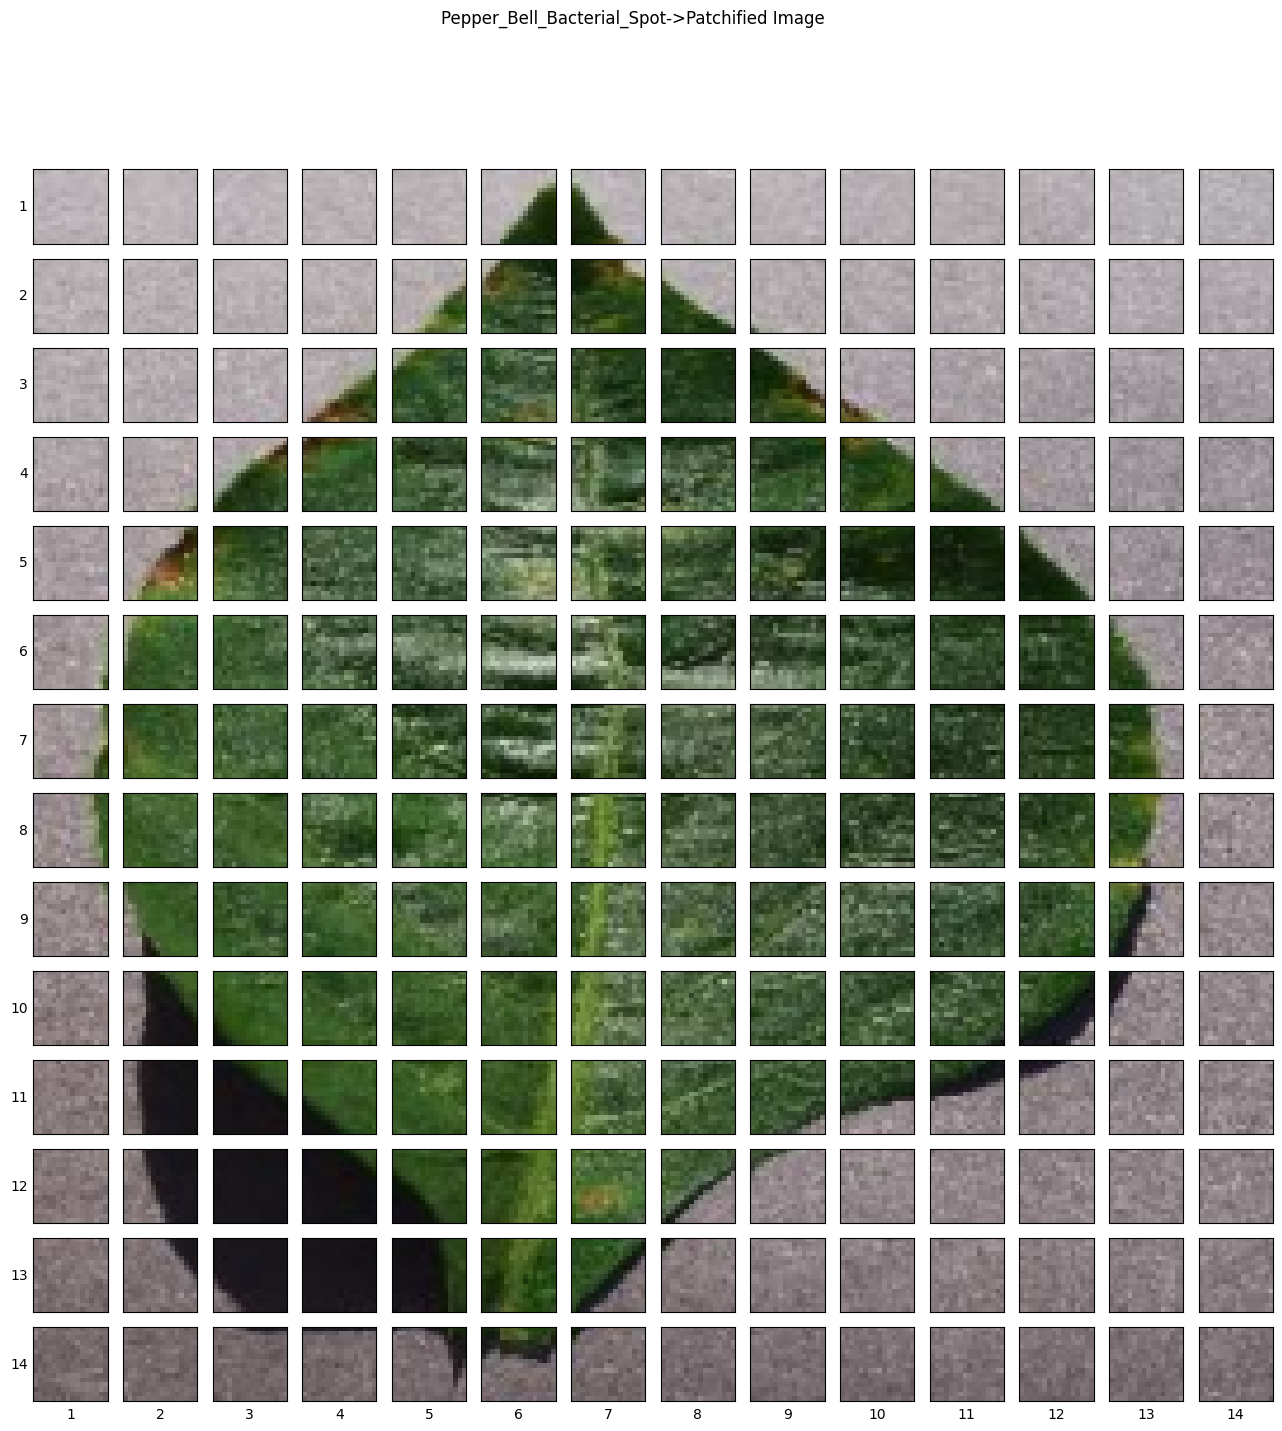

In [20]:
#Creating whole image plot in patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f"Number of patches per row/column : {num_patches} \n Patch Size {patch_size} pixels x {patch_size} pixels \n Total Patches : {num_patches*num_patches}")

#Create a series of Subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,#One column for each patch,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

#Loop through height and width
for i , patch_height in enumerate(range(0,img_size,patch_size)):
  for j , patch_width in enumerate(range(0,img_size,patch_size)):
    #Plot the permuted image on the different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,#Iterate through the height dimension
                                   patch_width:patch_width+patch_size,#Iterate through the width dimension
                                   :])
    #Setup label information for each subplot(patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()
# Setup a title for the plot
fig.suptitle(f"{class_names[label]}->Patchified Image")

### 4.3 Creating image patches and turning them into patch embeddings

Rather than using all the steps above , we can turn our image into patch embeddings in a single step by using `torch.nn.Conv2d()` and setting the stride and kernel_size to the `patch_size`.


In [21]:
#Create a Conv2d layer to turn image into patches of learnable feature maps(embeddings)
from torch import nn

#Set the patch_size
patch_size = 16

#Creating a conv2d layer with the hyperparameters given in the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768 , # The D size in Table 1
                   stride=patch_size,
                   kernel_size=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

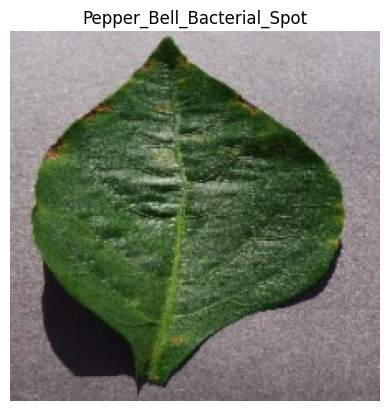

In [22]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

Now we need to pass the image through the convolutional layer

In [23]:
#Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))#Adding a batch dimension -> (batch_size, color_channels , height , width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now it is in the shape -> 1, 768, 14,14 , but we need to flatten the image and that is our next step

In [24]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes:[759, 281, 250, 228, 142]


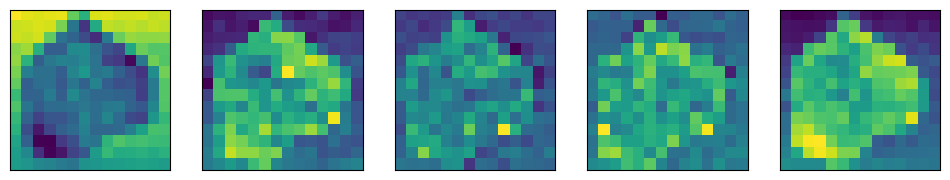

In [25]:
#Plot the random convolutional feature maps(embeddings)
import random
random_indexes = random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes:{random_indexes}")

#Create a plot
fig , axs  = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

#Plot the random image feature maps
for i,idx in enumerate(random_indexes):
   image_conv_feature_map = image_out_of_conv[:,idx,:,:]
   axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension , and remove from grad tracking/switch to numpy for matplotlib
   axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [26]:
#Get single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map

tensor([[[ 0.5666,  0.5659,  0.5509,  0.5528,  0.5282,  0.4626,  0.1533,
           0.5317,  0.5448,  0.5356,  0.5310,  0.5334,  0.5541,  0.5392],
         [ 0.5888,  0.5584,  0.5268,  0.5430,  0.5244,  0.2057,  0.0477,
           0.1046,  0.5415,  0.5397,  0.5535,  0.5162,  0.5441,  0.5132],
         [ 0.5070,  0.5358,  0.5266,  0.3867,  0.1443,  0.2127,  0.1955,
           0.0956,  0.0699,  0.3774,  0.5208,  0.5000,  0.4608,  0.4459],
         [ 0.4883,  0.4719,  0.0313,  0.1609,  0.2237,  0.3147,  0.2955,
           0.1489,  0.2129,  0.0345,  0.1359,  0.4767,  0.4536,  0.4924],
         [ 0.5065,  0.3352,  0.3044,  0.1818,  0.1876,  0.2991,  0.2659,
           0.1974,  0.1789,  0.0987,  0.0824, -0.0709,  0.4820,  0.4724],
         [ 0.4486,  0.1226,  0.1471,  0.1210,  0.2153,  0.4909,  0.3901,
           0.3745,  0.3961,  0.2135,  0.1725,  0.0643,  0.1669,  0.4819],
         [ 0.5168,  0.2109,  0.2111,  0.1611,  0.2011,  0.2998,  0.2508,
           0.1627,  0.1925,  0.1873,  0.0380,

### 4.4 Flattening the image patch

In [27]:
print(f"{image_out_of_conv.shape} -> [batch_size,embedding_dim,feature_map_height,feature_map_width]")


torch.Size([1, 768, 14, 14]) -> [batch_size,embedding_dim,feature_map_height,feature_map_width]


Want:(batch_size,number_of_patches,embedding_dim)

In [28]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image Shape:torch.Size([3, 224, 224])
Image shape after passing through Conv2d : torch.Size([1, 768, 14, 14])
Image Shape after flattening the image out of conv2d:torch.Size([1, 768, 196])


torch.Size([1, 196, 768])

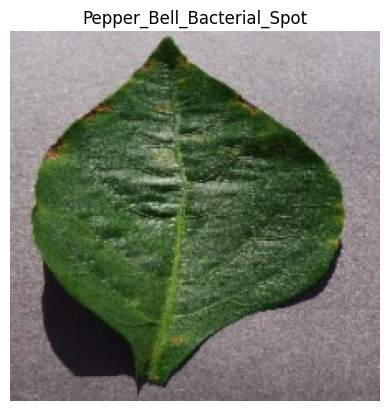

In [29]:
#Putting all together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original Image Shape:{image.shape}")

#Turn image into feature shape
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image shape after passing through Conv2d : {image_out_of_conv.shape}")

#Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image Shape after flattening the image out of conv2d:{image_out_of_conv_flattened.shape}")

#Reshaping the Flattened Feature map -> [batch_size , num_patches , embedding_size]
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_reshaped.shape

####  Now we want to get a visualisation of single flattened feature map and plotting them visually

In [30]:
#Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)
single_flattened_feature_map.shape

torch.Size([1, 196])

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

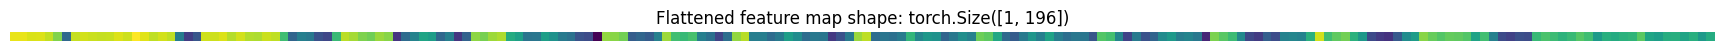

In [31]:
#Plot the above visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [32]:
single_flattened_feature_map , single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.5666,  0.5659,  0.5509,  0.5528,  0.5282,  0.4626,  0.1533,  0.5317,
           0.5448,  0.5356,  0.5310,  0.5334,  0.5541,  0.5392,  0.5888,  0.5584,
           0.5268,  0.5430,  0.5244,  0.2057,  0.0477,  0.1046,  0.5415,  0.5397,
           0.5535,  0.5162,  0.5441,  0.5132,  0.5070,  0.5358,  0.5266,  0.3867,
           0.1443,  0.2127,  0.1955,  0.0956,  0.0699,  0.3774,  0.5208,  0.5000,
           0.4608,  0.4459,  0.4883,  0.4719,  0.0313,  0.1609,  0.2237,  0.3147,
           0.2955,  0.1489,  0.2129,  0.0345,  0.1359,  0.4767,  0.4536,  0.4924,
           0.5065,  0.3352,  0.3044,  0.1818,  0.1876,  0.2991,  0.2659,  0.1974,
           0.1789,  0.0987,  0.0824, -0.0709,  0.4820,  0.4724,  0.4486,  0.1226,
           0.1471,  0.1210,  0.2153,  0.4909,  0.3901,  0.3745,  0.3961,  0.2135,
           0.1725,  0.0643,  0.1669,  0.4819,  0.5168,  0.2109,  0.2111,  0.1611,
           0.2011,  0.2998,  0.2508,  0.1627,  0.1925,  0.1873,  0.0380,  0.0948,
           0.198

We have turned our 2D image into learnable 1 dimensional Linear Learnable Embedding , now we need to put everything together into a PyTorch Module.

### 4.5 Turning the ViT Patch Embedding Layer into a PyTorch Module

We need to make all the above into a PyTorch module by subclassing nn.Module

For that we are following the steps below:

1. Create a class called `PatchEmbedding` which subclasses nn.Module (For reusability and structure).
2. Initialise the parameters with `in_channels` = 3 , `patch_size`= 16 and `embedding_dim`=768($D$ from ViT Base Table 1).
3. Create a Layer to turn an image into Patches
4. Create a Layer to flatten the patches
5. Define a forward() method to take an input and pass it through the layers in 3 and 4.
6. Check if the Output shape is the required output shape of the ViT Architecture.



In [33]:
# 1. Create a class named PatchEmbedding which subclass nn.Module
class PatchEmbedding(nn.Module):
  """This turns a 2D image into 1-Dimensional Learnable Patch Embedding

     Args: in_channels(int):Number of color channels for the input image(Default-3),
     patch_size(int): The size of the patches to convert the image into(Default-16),
     embedding_dim(int): The size of embedding to turn the image into (Default-768)

  """
  #2. Initialise the classes with appropriate values
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
      super().__init__()

      #3. Create a layer to turn an image into patch
      self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

      #4. Create a layer to flatten the image
      self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                end_dim=3)

  #5. Define Forward method
  def forward(self,x):
      #Create assertion to check the inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

      #Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      #6. Check if the output is the required Output shape for ViT architecture
      return x_flattened.permute(0,2,1)

In [34]:
#Trying the above in a single image

#Create an instance of patch_embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
#Pass a single image through
print(f"Input Shape:{image.shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output Shape:{patch_embedded_image.shape}")



Input Shape:torch.Size([3, 224, 224])
Output Shape:torch.Size([1, 196, 768])


Now we have replicated the patch embedding , and the next steps is to create the learnable class embedding and position embeddings which will complete the Equation 1 from the ViT Paper.

### 4.6 Creating the class token embedding

In this section we need to prepend a learnable embedding to the sequence of embedded patches.

In [35]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6354,  0.6988, -0.2314,  ...,  0.3455, -0.2747, -0.4689],
         [-0.6287,  0.7047, -0.2099,  ...,  0.3428, -0.2630, -0.4529],
         [-0.6438,  0.6926, -0.2302,  ...,  0.3532, -0.2655, -0.4861],
         ...,
         [-0.3777,  0.4255, -0.1558,  ...,  0.2129, -0.1614, -0.2801],
         [-0.3683,  0.4195, -0.1720,  ...,  0.2255, -0.1613, -0.2923],
         [-0.4110,  0.4293, -0.1316,  ...,  0.2551, -0.1476, -0.2757]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [37]:
#Create a class token embedding as a learnable parameter that share the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
#Show the first 10 Examples
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [38]:
#Add the class token embedding to the front of patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),
                                                  dim=1) #Number of patch dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepend shape:{patch_embedded_image_with_class_embedding.shape} ->(batch_size,class_token+number_of_patches,embedding_dim)")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6354,  0.6988, -0.2314,  ...,  0.3455, -0.2747, -0.4689],
         [-0.6287,  0.7047, -0.2099,  ...,  0.3428, -0.2630, -0.4529],
         ...,
         [-0.3777,  0.4255, -0.1558,  ...,  0.2129, -0.1614, -0.2801],
         [-0.3683,  0.4195, -0.1720,  ...,  0.2255, -0.1613, -0.2923],
         [-0.4110,  0.4293, -0.1316,  ...,  0.2551, -0.1476, -0.2757]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepend shape:torch.Size([1, 197, 768]) ->(batch_size,class_token+number_of_patches,embedding_dim)


We have successfully created the class token and prepend it to the patch embedding , Now we need to create position embedding and add them to the sequence of patch embeddings.

### 4.7 Create Position Embeddings

We need to create 1D learnable position embeddings and add them to sequence of patch embeddings.

In [39]:
#View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding , patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6354,  0.6988, -0.2314,  ...,  0.3455, -0.2747, -0.4689],
          [-0.6287,  0.7047, -0.2099,  ...,  0.3428, -0.2630, -0.4529],
          ...,
          [-0.3777,  0.4255, -0.1558,  ...,  0.2129, -0.1614, -0.2801],
          [-0.3683,  0.4195, -0.1720,  ...,  0.2255, -0.1613, -0.2923],
          [-0.4110,  0.4293, -0.1316,  ...,  0.2551, -0.1476, -0.2757]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
#Calculate the Number of Patches
number_of_patches = int((height*width)/patch_size**2)

#Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Create the 1D learnable 1D Position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding , position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [41]:
#Adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of Patch and Position embedding:{patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3646, 1.6988, 0.7686,  ..., 1.3455, 0.7253, 0.5311],
         [0.3713, 1.7047, 0.7901,  ..., 1.3428, 0.7370, 0.5471],
         ...,
         [0.6223, 1.4255, 0.8442,  ..., 1.2129, 0.8386, 0.7199],
         [0.6317, 1.4195, 0.8280,  ..., 1.2255, 0.8387, 0.7077],
         [0.5890, 1.4293, 0.8684,  ..., 1.2551, 0.8524, 0.7243]]],
       grad_fn=<AddBackward0>)
Shape of Patch and Position embedding:torch.Size([1, 197, 768])


### 4.8 Combining all Together to complete the Equation 1

We can do by following the steps below:

1. Set the patch size = 16.
2. Getting a single image , print and store its shape.
3. Add a batch dimension to the single image so it's comparable with our `PatchEmbedding` layer.

4. Creating a PatchEmbedding layer  with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding.
7. Prepending the class token embedding to the patch embeddings.
8. Creating a position embedding.
9. Adding the position embedding to the class token and patch embeddings.

In [42]:
#1. Set the patch size
patch_size = 16

#2. Getting a single image , print and store it's shape
print(f"Image Tensor Shape:{image.shape}")
height , width = image.shape[1] , image.shape[2]

#3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Image with additional batch dimension shape:{x.shape}")

#4. Create Patch Embedding Layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                          patch_size=patch_size,
                          embedding_dim=768)
#5. Passing the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape:{patch_embedding}")

#6. Create the class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
print(f"Class Token embedding shape: {class_token.shape}")

#7. Prepend class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token,patch_embedding),
                                             dim=1)
print(f"Patch Embedding with class token shape:{patch_embedding_with_class_token.shape}")

#8. Create position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) #Make sure its learnable

#9.Add position embedding with patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and Position embedding shape:{patch_and_position_embedding.shape}")

Image Tensor Shape:torch.Size([3, 224, 224])
Image with additional batch dimension shape:torch.Size([1, 3, 224, 224])
Patch Embedding Shape:tensor([[[-0.1905, -0.2299,  0.7847,  ..., -0.4284, -0.0437, -0.7472],
         [-0.1997, -0.2073,  0.7831,  ..., -0.4345, -0.0091, -0.7431],
         [-0.2111, -0.2086,  0.7922,  ..., -0.4440, -0.0366, -0.7413],
         ...,
         [-0.1224, -0.1126,  0.4693,  ..., -0.2363,  0.0162, -0.4712],
         [-0.1257, -0.1308,  0.4946,  ..., -0.2691, -0.0096, -0.4083],
         [-0.1334, -0.0807,  0.5193,  ..., -0.2420,  0.0265, -0.4866]]],
       grad_fn=<PermuteBackward0>)
Class Token embedding shape: torch.Size([1, 1, 768])
Patch Embedding with class token shape:torch.Size([1, 197, 768])
Patch and Position embedding shape:torch.Size([1, 197, 768])


We have successfully turned the Equation 1 in the ViT paper into usable PyTorch , now it is time to move to the Equation 2: Multi-Head Attention(MSA)

## 5. Equation 2:Mulit-Head Self Attention


<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/3.png?raw=true" width=900 alt="equation 3 explained visually"/>


From the figure we can also see the Norm Layer along with the MSA layer , and residual connection with '+' sign is also seen within the block.

These all are implemented in PyTorch and inorder to replicate this we can use 🇰
1. **Multi-head Self Attention** - `torch.nn.MultiheadAttention()`
2. **Layer Norm** - `torch.nn.LayerNorm()`
3. **Residual Connection** - Add input to the resulting output

* Multihead Self-Attention : Which part of a sequence should pay the most attention to itself?
  * In our case , we have a series of embedded image patches , which patches significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in pytorch:
* LayerNorm = Layer Normalization is technique to normalise the distributions of intermediate layers. It enables smoother gradients , faster training, and beter generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
    * When we normalize along the embedding dimension , it's like making all of the stairs in a staircase the same size.




## **Table 1**


| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |
    

Similar to creating the PatchEmbeddingClass , we can create a PyTorch class for MultiHeadSelfAttentionBlock using `torch.nn.Module` , before that we need to follow the steps below:

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`.
2. Initialise the class with the base hyperparameters from the Table 1 of the ViT paper.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.

In [43]:
#1. Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
   """ Creates a MultiHeadSelfAttentionBlock
   """
   #2. Initialise the class with hyperparameters from Table 1.
   def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:float=0):
       super().__init__()

       #3. Create the Norm Layer (LN)
       self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

       #4. Create a multi-head attention
       self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                        num_heads=num_heads,
                                                        dropout=attn_dropout,
                                                        batch_first=True)

   #5. Create a forward() method to pass the data through the layers
   def forward(self,x):
     x = self.layer_norm(x)
     attn_output , _ = self.multihead_attn(query=x, #Query embeddings
                                           key=x, #Key embeddings
                                           value=x, #Value embeddings
                                           need_weights=False)
     return attn_output

Now we have created a MultiheadSelfAttentionBlock , now we need to create an instance and pass the patchembeddings through it.

In [44]:
#Create an instance of MSA Block
msa_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                        num_heads=12)
#Passing the patch and position embedding through msa block
patched_image_through_msa_block = msa_block(patch_and_position_embedding)
print(f"Patched image before passing through msa_block shape:{patch_and_position_embedding.shape}")
print(f"Patched image after passing through msa_block shape:{patched_image_through_msa_block.shape}")

Patched image before passing through msa_block shape:torch.Size([1, 197, 768])
Patched image after passing through msa_block shape:torch.Size([1, 197, 768])


## 6. Replicating Equation 3: Multi-Layer Perceptron Block

The MLP block contain 2 layers with GeLU Non-linearity


  * MLP = a quite broad term for a layer a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * MLP - no. of hidden units, MLP size in Table 1
  * Layers can mean: fully-connected , dense, linear , feed-forward , all are often similar names for the same thing. In PyTorch , they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`

  * **Dropout** =  
  value available in Table 3

In pseudocode:

```python
#MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


To recreate the MLP Equation we need to follow the following steps:


1. Create a class called MLPBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a sequential series of MLP layers(s) using torch.nn.Linear(), torch.nn.Dropout() and torch.nn.GELU() with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [45]:
class MLPBlock(nn.Module):
  """Creates an MLP Block
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1): #From table 1 of the ViT paper
      super().__init__()

      #Create the norm layer (LN)
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
      #create an MLP layer
      self.mlp = nn.Sequential(
          nn.Linear(in_features=embedding_dim,
                    out_features=mlp_size),
          nn.GELU(),
          nn.Dropout(p=dropout),
          nn.Linear(in_features=mlp_size,
                    out_features=embedding_dim),
          nn.Dropout(p=dropout)
          )
  # 5. Create a forward() method to pass the data through the layers
  def forward(self, x):
      x = self.layer_norm(x)
      x = self.mlp(x)
      return x


In [46]:
#Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

#Passing Patched image through the MLP BLock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Patched image before passing through mlp_block shape:{patched_image_through_msa_block.shape}")
print(f"Patched image after passing through mlp_block shape:{patched_image_through_mlp_block.shape}")

Patched image before passing through mlp_block shape:torch.Size([1, 197, 768])
Patched image after passing through mlp_block shape:torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder Block

Now its time to put the MSA Layer and MLP layer together to create the Transformer Encoder Block , and We need to add residual connections , in the ViT paper it means that , we add the input of the MSA Block with the output of it , and input of MLP Block is added with it's output as well.

in Pseudocode:

```python
   
   x_input -> MSA Layer -> (MSA_layer_output + x_input) -> MLP Layer -> (MLP_layer_output + (MSA_Layer_output + x_input)) -> .........

```

Now let's put things together

To do so, we'll:

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a forward() method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [47]:
#Create a class called TransformerEncoderBlock
class TransformerEncoderBlock(nn.Module):
  """Creates a Transformer Encoder Block
  """
  def __init__(self,
               embedding_dim:int=768, #Hidden Size D from VIT Table 1
               mlp_size:int=3072, #MLP Size from Table 1
               mlp_dropout:int=0.1, #Dropout for Dense layers
               num_heads:int=12, #Number of heads from Table 1
               attn_dropout:float=0): #Dropout for attention Layers
      super().__init__()

      #Create the layer Norm
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      #Create the MSA Block
      self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim ,
                                                   num_heads=num_heads,
                                                   attn_dropout=attn_dropout)
      #Create the MLP Block
      self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                mlp_size=mlp_size,
                                dropout=mlp_dropout)
  # Create a feed forward network
  def forward(self,x):
      x = self.msa_block(x) + x # Create a residual connection for the MSA Block
      x = self.mlp_block(x) + x # Create a residual connection for the MLP Block

      return x

Now we have successfuly created a Transformer Encoder Block!!

In [48]:
pip install torchinfo

In [49]:
from torchinfo import summary
#Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

#Get a summary using torch.info.summary
summary(model=transformer_encoder_block,
        input_size=(1,197,768), #(batch_size,number_of_patches,embedding_dimension)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with in-Built PyTorch Layers

We have created a transformer enocoder by hand.

The same thing is implemented by PyTorch , we can create a transformer encoder layer with Pure Pytorch.


In [50]:
#Create the same as the above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=768,#Embedding_Size
                                                                   nhead=12,#Head from Table 1
                                                                   dim_feedforward=3072,#MLP Size from Table 1
                                                                   dropout=0.1,
                                                                   activation="gelu",
                                                                   batch_first=True,
                                                                   norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [51]:
#Get a summary using torch.info.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768), #(batch_size,number_of_patches,embedding_dimension)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

We have just created a Transformer Encoder Block with just one line of code in PyTorch!!!


What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benefit of speed ups (performance boosts)

## 8. Putting it All together To Create ViT

In [52]:
#Create ViT Class
class ViT(nn.Module):
   """
   Create VIT
   """
   def __init__(self,
                img_size:int=224, #Size from Table 1
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12 , #Table 1 for "Layers" for ViT Base
                embedding_dim:int=768, #Hidden Size D from Table 1
                mlp_size:int=3072,#Table 1
                num_heads:int=12, #Table 1
                attn_dropout:int=0,
                mlp_dropout:int=0.1,#Dropout for patch and position embeddings
                embedding_dropout:int=0.1,#Dropout for patch and position embeddings
                num_classes:int=1000): #Number of classes in our classification problem
      super().__init__()

      #Make sure that the image size is compatible with the patch size
      assert img_size % patch_size == 0 ,f"Image size must be divisible by patch size , image size: {img_size}, patch size: {patch_size}"

      #Calculate the number of patches (height * width/patch**2)
      self.num_patches = (img_size * img_size)//patch_size**2
      self.patch_size = patch_size

      #Create learnable class embedding
      self.class_embedding = nn.Parameter(data=torch.rand(1,1,embedding_dim),
                                        requires_grad=True)

      #Create the position embedding
      self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim))

      #Create the embedding dropout value
      self.embedding_dropout = nn.Dropout(p=embedding_dropout)

      #Create patch embedding layer
      self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

      #Create the Transformer Encoder Block
      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

      #Create the Classifier Head
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)
            )

   #Forward Pass
   def forward(self,x):
    #Get the batch size
    batch_size = x.shape[0]
    #Create class token and  expand it to match the batch size (Eq1)
    class_token = self.class_embedding.expand(batch_size,-1,-1) # "-1" to infer the dimensions

    #Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    #Combine class token embedding to patch embedding
    x = torch.cat((class_token,x),dim=1) #(batch_size , number_of_patches , embedding_dim)

    #Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    #Adding dropout after adding position embeddings
    x = self.embedding_dropout(x)

    #Pass position and patch embedding to Transformer Encoder (Eq2 and Eq3)
    x = self.transformer_encoder(x)

    #Put the 0th index logit through classifier (Eq4)
    x =self.classifier(x[:,0])


    return x


In [53]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=Tru

In [54]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [55]:
#Create a random tensor with same shape as a single image
random_tensor = torch.randn(1,3,224,224)

#Create an instance of ViT with Number of classes we're working with (Plant Diseases)
vit = ViT(num_classes=len(class_names))

#Pass the random tensor to the ViT
vit(random_tensor)

tensor([[-0.2853,  0.6250,  0.1495, -0.0163,  0.2333,  0.5711, -0.1296, -1.0847]],
       grad_fn=<AddmmBackward0>)

In [56]:
from torchinfo import summary

#Get a summary using torchinfo.summary
summary(model=vit,
        input_size=(32,3,224,224), #(batch_size,color_channels,height, width)
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape
ViT (ViT)                                                    [32, 3, 224, 224]
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]
│    └─Flatten (flatten)                                     [32, 768, 14, 14]
├─Dropout (embedding_dropout)                                [32, 197, 768]
├─Sequential (transformer_encoder)                           [32, 197, 768]
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│    └─TransformerEncoderBlock (1)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│  

## 9. Setting up Training Code for our ViT

We have replicated the ViT architecture now we need to check how it performs on our EmotionVision Mini Dataset

### 9.1 Creating an optimizer

In [57]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)


The paper states it uses the Adam Optimizer (Section 4 , Training & Fine-Tuning) with $B1$ value of 0.9 , $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight Decay

Regularization technique = Prevent Overfitting.

### 9.2 Creating a Loss function

The ViT Paper does'nt actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

In [58]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our Vision Transformer Model (ViT)

In [ ]:
from going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       epochs=10,
                       loss_fn=loss_fn,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

### 9.4 What is our training setup is missing

How is our training setup different to the ViT Paper?

We've replicated model architecture correctly.

But what was different between our training procedure to get such poor results and ViT paper training procedure to get great results?

The main things our training implementation is missing:

Prevent Underfitting:

* Data - our setup uses far less data (225 vs Millions)

Prevent Overfitting:
* Learning Rate Warmup - Start with a low learning rate and increase to a Base LR
* Learning Rate Decay - As your model gets closer to convergence , start to lower the learning rate
* Gradient Clipping - Prevent Gradients from getting too big


### 9.5 Plotting loss curves for our model

In [ ]:
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Use a pretrained ViT from `torchvision.models`

Generally , in deep learning if you can use a pretrained model from a large datasets on your problem, it's often a good place to start.iter

If you can find a pretrained model and use transfer learnging , give it a go , it often achieves great results with little data.


**Why use a pretrained model?**

* Sometimes data is limited
* Limited Training resources
* Get better results faster(sometimes)

In [ ]:
# The following requires torch v0.12+ and torchvision 0.13
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
from going_modular.helper_functions import download_data

# Download Plant Disease images from GitHub
image_path = download_data(source="hhttps://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/data/Plant_Disease_ViT.zip",
                           destination="plant_disease")

image_path

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [ ]:
#Get pretrained weights for ViT Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT #DEFAULT = Best Weights

#Setup a ViT model instance with pretrained weights
pretrained_vit_model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#Freeze the base parameters
for parameter in pretrained_vit_model.parameters():
    parameter.requires_grad = False

#Update the classifier
set_seeds()
pretrained_vit_model.heads = nn.Linear(in_features=768,
                                       out_features=len(class_names)).to(device)

In [ ]:
from torchinfo import summary

#Get a summary using torchinfo.summary
summary(model=pretrained_vit_model,
        input_size=(32,3,224,224), #(batch_size, color_channels , height , width)
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model , you want to make sure your data is formatted in the same way that the model was trained on.

In [ ]:
 # Get automatic transforms from pretrained ViT weights
 vit_transforms = pretrained_vit_weights.transforms()
 vit_transforms

In [ ]:
# Setup dataloaders
from going_modular import data_setup
train_dataloader_pretrained , test_dataloader_pretrained ,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                      test_dir=test_dir,
                                                                                                      transform=vit_transforms,
                                                                                                      batch_size=32) #COuld set a higher batch size because using a pretrained model

### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(params=pretrained_vit_model.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=pretrained_vit_model,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       epochs=20,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)


In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 10.6 Save our best performing ViT Base Models

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize becauase if we wanted tot deploy a model to say a website/mobile application , we may have limitations on the size of the model we can deploy.

Eg. A smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit_model,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_plant_disease.pth")


In [ ]:
from pathlib import Path

#Get model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_plant_disease.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size : {pretrained_vit_model_size} MB")

## 11. Predicting on a Custom Image

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "happy_man.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/happy_man.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


print("Prediction on Pretrained ViT")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit_model,
                    image_path=custom_image_path,
                    class_names=class_names)



In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "happy_man.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/happy_man.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

print(f"Prediction on ViT Built from Scratch")

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)


In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "sad_jesse.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/sad_man.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

print(f"Prediction on ViT Built From Scratch")

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)


In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "sad_man.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/sad_man.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

print(f"Prediction from Pretrained ViT")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit_model,
                    image_path=custom_image_path,
                    class_names=class_names)



In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "angry_man.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/angry_man.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

print(f"Prediction on Pretrained ViT")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit_model,
                    image_path=custom_image_path,
                    class_names=class_names)



In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "angry_man.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/images/angry_man.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

print(f"Prediction on ViT built from Scratch")

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

